In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')
plt.rc('font', family='NanumBarunGothic')
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
path='/content/drive/MyDrive/lstm_dacon/'
df= pd.read_csv(path+"train.csv")
answer = pd.read_csv(path+"sample_submission.csv")

In [ ]:
"""
일조합과 일사합은 태양의 빛과 관련된 용어로, 기상학에서 중요한 요소입니다.

일조합(日照合): 일조합은 특정 장소에서 실제로 태양 빛이 도달하는 시간의 총합을 말해요.
기상 관측에서는 보통 하루 동안 태양 빛이 땅에 닿는 시간을 측정하며, 이를 일조시간이라고 합니다.
그리고 일정 기간 동안의 일조시간을 모두 더한 것이 일조합이죠.
일사합(日射合): 일사합은 일정 기간 동안 태양으로부터 받은 총 일사 에너지의 양을 말합니다.
일사량은 태양 복사 에너지가 지표면에 닿는 양을 말하고,
이를 측정하는 것은 태양의 에너지가 실제로 얼마나 지구에 도달했는지를 알려주는 중요한 지표가 됩니다.
일조율 : 흐림정도
"""

df.isna().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

In [ ]:
null_cols = ['최고기온', '최저기온','평균풍속']
for col in null_cols:
  df[col].interpolate(method='linear', inplace=True)

In [ ]:
df['일교차']=df['최고기온']-df['최저기온']
df['강수량']=df['강수량'].fillna(0)

In [ ]:
for i in df[df[['일조율']].isnull().any(axis=1)].index:
    df.loc[i,'일조율']=df[df['일조합']==df.loc[i]['일조합']]['일조율'].median()
for i in df[df[['일조합']].isnull().any(axis=1)].index:
    df.loc[i,'일조합']=df[df['일조율']==df.loc[i]['일조율']]['일조합'].median()
for i in df[df[['일사합']].isnull().any(axis=1)].index:
    df.loc[i,'일사합']=df[df['일조합']==df.loc[i]['일조합']]['일사합'].median()

In [ ]:
df.isna().sum()

일시      0
최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

In [ ]:
# print(df.iloc[:,1:].corr())
# sns.heatmap(df.iloc[:,1:].corr())

In [ ]:
df['월'] = df['일시'].str[5:7]

In [ ]:
# 월을 기반으로 계절 생성
def create_season(month):
    if month in ['03', '04', '05']:
        return '봄'
    elif month in ['06', '07', '08']:
        return '여름'
    elif month in ['09', '10', '11']:
        return '가을'
    else:
        return '겨울'

# '월' 컬럼으로부터 '계절' 컬럼 생성
df['계절'] = df['월'].apply(create_season)

# One-Hot Encoding 생성
df_encoded = pd.get_dummies(df, columns=['계절'])

In [ ]:
length=1100
X_train_data=df_encoded[['최고기온','평균습도','평균풍속','일조합','일사합','계절_가을','계절_겨울','계절_봄','계절_여름','평균기온']]
X_train=X_train_data.iloc[:-length,:]
X_test=X_train_data.iloc[-length:,:]

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_train = X_train.astype('float32')
mx=MinMaxScaler()
ss=StandardScaler()
mx_feature_data=ss.fit_transform(X_train)
X_train=mx_feature_data
y_train = df_encoded[['최고기온']]
X_train_data = []
y_train_data = []

for i in tqdm(range(length, len(X_train) - len(answer))):
    X_train_data.append(X_train[i - length:i])
    y_train_data.append(y_train.values[i:i + len(answer), -1])

X_train_data = np.array(X_train_data, dtype=np.float32)  # float32 타입으로 배열 생성
y_train_data = np.array(y_train_data, dtype=np.float32)  # float32 타입으로 배열 생성

100%|██████████| 20453/20453 [00:00<00:00, 198394.32it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, BatchNormalization, Flatten, Dropout
import numpy as np

input1 = tf.keras.Input(shape=(X_train_data.shape[1], X_train_data.shape[2]))
bi_lstm1 = LSTM(32, activation='tanh', return_sequences=False)(input1)
output1 = Dense(64, activation='swish')(bi_lstm1)
output2 = Dense(128, activation='swish')(output1)
output4 = Dense(y_train_data.shape[1])(output2)

model = tf.keras.Model(inputs=input1, outputs=output4)
model.compile(loss='mse', optimizer='Nadam', metrics=['mean_absolute_error'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1100, 10)]        0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                5504      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 358)               46182     
                                                                 
Total params: 62118 (242.65 KB)
Trainable params: 62118 (242.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train_data, y_train_data, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
320/320 [==============================] - 14s 30ms/step - loss: 81.8438 - mean_absolute_error: 6.0163
Epoch 2/20
320/320 [==============================] - 11s 34ms/step - loss: 14.4412 - mean_absolute_error: 3.0043
Epoch 3/20
320/320 [==============================] - 11s 34ms/step - loss: 13.9857 - mean_absolute_error: 2.9570
Epoch 4/20
320/320 [==============================] - 11s 34ms/step - loss: 13.8742 - mean_absolute_error: 2.9455
Epoch 5/20
320/320 [==============================] - 11s 34ms/step - loss: 13.7903 - mean_absolute_error: 2.9372
Epoch 6/20
320/320 [==============================] - 15s 45ms/step - loss: 13.7132 - mean_absolute_error: 2.9287
Epoch 7/20
320/320 [==============================] - 11s 35ms/step - loss: 13.6381 - mean_absolute_error: 2.9203
Epoch 8/20
320/320 [==============================] - 10s 32ms/step - loss: 13.5813 - mean_absolute_error: 2.9138
Epoch 9/20
320/320 [==============================] - 11s 35ms/step - loss: 13.5334 - me

In [ ]:
ss_test_feature_data=ss.transform(X_test)
X_test_predict_data=ss_test_feature_data

In [ ]:
X_test_predict_data.shape
X_test_predict_data=X_test_predict_data.reshape((1,) + X_test_predict_data.shape)

In [ ]:
X_test_predict_data.shape

(1, 1100, 10)

In [ ]:
t=model.predict(X_test_predict_data)

1/1 [==============================] - 0s 30ms/step


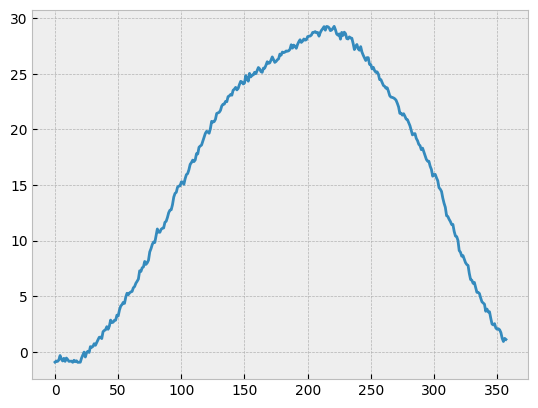

In [ ]:
plt.plot(t[0])

In [ ]:
answer['평균기온']=t[0]
answer.to_csv('answer.csv',index=False)